# PIT Summary nonlinear

# Purpose
There has been a lot done in the parameter identification techniques (PIT) in this project, this notebook is a summary.

# Setup

In [1]:
# %load imports.py
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

#import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
#import src.models.nonlinear_martin_vmm as vmm
#import src.nonlinear_martin_vmm_equations as eq

#import src.models.linear_vmm as vmm
import src.nonlinear_martin_vmm_equations as eq

#import src.models.linear_vmm as model
from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot
from src.equation import Equation

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
Math(vlatex(eq.X_eq))

<IPython.core.display.Math object>

In [3]:
Math(vlatex(eq.Y_eq))

<IPython.core.display.Math object>

In [4]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

In [5]:
Math(vlatex(eq.X_eq.rhs-eq.X_eq.lhs))

<IPython.core.display.Math object>

In [6]:
Math(vlatex(eq.Y_eq.rhs-eq.Y_eq.lhs))

<IPython.core.display.Math object>

In [7]:
Math(vlatex(eq.N_eq.rhs-eq.N_eq.lhs))

<IPython.core.display.Math object>

## Load test

In [8]:
#id=22773
#id=22616
id=22774
#id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df['t'] = df.index
df.sort_index(inplace=True)
df['-delta'] = -df['delta']
df['V'] = np.sqrt(df['u']**2 + df['v']**2)

df['thrust'] = df['Prop/PS/Thrust'] + df['Prop/SB/Thrust']
df['U'] = df['V']
df['beta'] = -np.arctan2(df['v'],df['u'])

In [9]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']

<AxesSubplot:xlabel='time'>

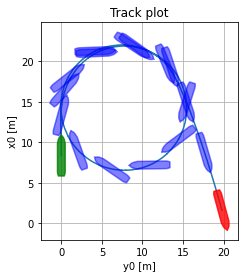

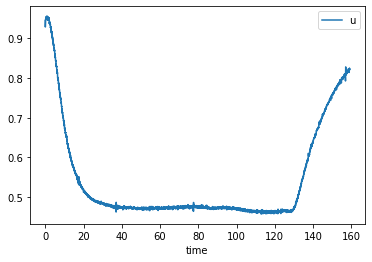

In [10]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);
df.plot(y='u')

# Ship parameters

In [11]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2
#I_z_=839.725

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        #'x_G' : meta_data.lcg,  # motions are expressed at CG
        'x_G' : 0,  # motions are expressed at CG
        
        'm' : m_,
        'I_z': I_z_, 
        'volume':meta_data.Volume,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship
ship_parameters_prime = ps.prime(ship_parameters)

In [12]:
I_z_+m_*meta_data.lcg**2  # Steiner rule...

719.4503668233929

In [13]:
I_z_

693.124396594905

In [14]:
ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858}

In [15]:
ship_parameters_prime

{'T': 0.04114230396902224,
 'L': 1.0,
 'CB': 0.45034232324249973,
 'B': 0.1887705711519845,
 'rho': 2.0,
 'x_G': 0.0,
 'm': 0.006995127873817863,
 'I_z': 0.00043719549211361644,
 'volume': 0.003497563936908932}

## Prime system

In [16]:
interesting = ['x0','y0','psi','u','v','r','u1d','v1d','r1d','U','t','delta','thrust','beta']
df_prime = ps.prime(df[interesting], U=df['U'])
df_prime.set_index('t', inplace=True)

<AxesSubplot:xlabel='t'>

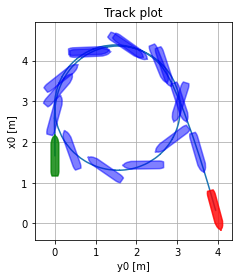

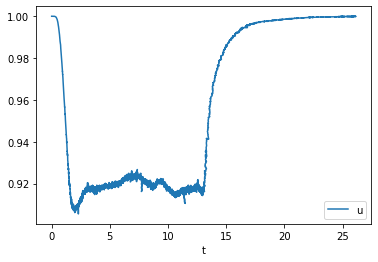

In [17]:
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],
           x_dataset='x0', y_dataset='y0',  psi_dataset='psi', ax=ax);

df_prime.plot(y='u')

In [18]:
df.index

Float64Index([                 0.0, 0.010002000000000066, 0.020001999999999853,
               0.03002200000000066,  0.04000199999999943,  0.05000099999999996,
               0.06000200000000078,   0.0700219999999998,  0.08000099999999932,
                0.0899990000000006,
              ...
                        159.050005,           159.060013,               159.07,
                        159.080005,           159.090005,           159.100006,
                        159.110017,           159.120001,           159.130005,
                        159.140008],
             dtype='float64', name='time', length=15915)

In [19]:
df_prime.index

Float64Index([                  0.0, 0.0018590505176670773,
               0.003703278795339165,  0.005567789136387368,
                0.00743809610775319,  0.009300584387083548,
                0.01116513279812117,   0.01306781836916762,
               0.014973821105671309,  0.016852159385169353,
              ...
                 26.016530241872566,     26.08549683298727,
                 26.155073443087844,     26.15859030345773,
                 26.144083237296872,     26.12877144218778,
                 26.116362811864647,    26.101964884226014,
                  26.08629050013182,    26.075838054271756],
             dtype='float64', name='t', length=15915)

In [20]:
t_ = np.array([0,1,2])
U_ = np.array([1,2,2])
t_prime = ps._prime(t_, unit='time', U=U_)
t_prime

array([0.        , 0.39883833, 0.79767667])

In [21]:
ps._unprime(t_prime, unit='time', U=U_)

array([0., 1., 2.])

# Brix parameters

In [22]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)


mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)

df_parameters.loc['Ydelta','brix_prime'] = 0.0004  # Just guessing
df_parameters.loc['Ndelta','brix_prime'] = -df_parameters.loc['Ydelta','brix_prime']/4  # Just guessing

df_parameters['brix_prime'].fillna(0, inplace=True)
#df_parameters['brix_SI'].fillna(0, inplace=True)



## Simulate with Brix

In [23]:
X_eq = eq.X_eq.copy()
Y_eq = eq.Y_eq.copy()
N_eq = eq.N_eq.copy()


#subs=[
#    #(x_G,0),
#    (eq.p.Xvdot,0),
#    (eq.p.Xrdot,0),
#    (eq.p.Yudot,0),
#    (eq.p.Yrdot,0),
#    (eq.p.Nudot,0),
#    (eq.p.Nvdot,0),   
#]
#
#X_eq = X_eq.subs(subs)
#Y_eq = Y_eq.subs(subs)
#N_eq = N_eq.subs(subs)

u1d,v1d,r1d = sp.symbols('u1d, v1d, r1d')
subs = [
    (u.diff(),u1d),
    (v.diff(),v1d),
    (r.diff(),r1d),

]
eq_X_ = X_eq.subs(subs)
eq_Y_ = Y_eq.subs(subs)
eq_N_ = N_eq.subs(subs)


A,b = sp.linear_eq_to_matrix([eq_X_,eq_Y_,eq_N_],[u1d,v1d,r1d])

acceleartion_eq = A.inv()*b
## Lambdify:
subs = {value:key for key,value in eq.p.items()}
subs[X_qs] = sp.symbols('X_qs')
subs[Y_qs] = sp.symbols('Y_qs')
subs[N_qs] = sp.symbols('N_qs')

acceleartion_lambda = lambdify(acceleartion_eq.subs(subs))





In [24]:
acceleartion_lambda

<function _lambdifygenerated(I_z, Ndelta, Ndeltadeltadelta, Nr, Nrdeltadelta, Nrdot, Nrrdelta, Nrrr, Nudelta, Nudot, Nur, Nuu, Nuudelta, Nuur, Nuuv, Nuv, Nv, Nvdeltadelta, Nvdot, Nvrdelta, Nvrr, Nvvdelta, Nvvr, Xdeltadelta, Xrdelta, Xrdot, Xrr, Xthrust, Xu, Xudeltadelta, Xudot, Xurdelta, Xurr, Xuu, Xuuu, Xuvr, Xuvv, Xvdelta, Xvdot, Xvr, Xvrdelta, Xvv, Ydelta, Yr, Yrdot, Yrrr, Yudelta, Yudot, Yur, Yuu, Yuudelta, Yuur, Yuuv, Yuv, Yv, Yvdeltadelta, Yvdot, Yvrdelta, Yvrr, Yvvr, Yvvv, delta, m, r, thrust, u, v, x_G)>

In [25]:
from scipy.spatial.transform import Rotation as R

def step(t, states, parameters, ship_parameters, control):

    u,v,r,x0,y0,psi = states
    
    if u < 0:
        dstates = [
        0,
        0,
        0,
        0,
        0,
        0,
        ]    
        return dstates
    
    states_dict = {
        'u':u,
        'v':v,
        'r':r,
        'x0':x0,
        'y0':y0,
        'psi':psi,
        
        }
    
    inputs = dict(parameters)
    inputs.update(ship_parameters)
    inputs.update(states_dict)
    
    if isinstance(control, pd.DataFrame):
        index = np.argmin(np.array(np.abs(control.index - t)))
        control_ = dict(control.iloc[index])
    else:
        control_ = control
    inputs.update(control_)
    
    inputs['U'] = np.sqrt(u**2 + v**2)  #Instantanious velocity
    u1d,v1d,r1d = run(function=acceleartion_lambda, inputs=inputs)
    
    rotation = R.from_euler('z', psi, degrees=False)
    w = 0
    velocities = rotation.apply([u,v,w])
    x01d = velocities[0]
    y01d = velocities[1]
    psi1d = r    
    dstates = [
        u1d,
        v1d,
        r1d,
        x01d,
        y01d,
        psi1d,
    ]    
    return dstates

<AxesSubplot:xlabel='t'>

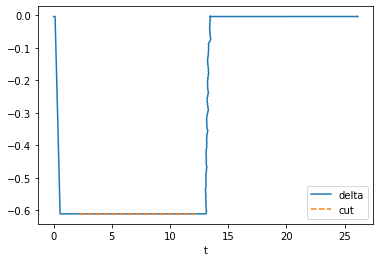

In [26]:
fig,ax=plt.subplots()
df_prime.plot(y='delta', ax=ax)
df_cut_prime = df_prime.iloc[2000:12000]
df_cut_prime.plot(y='delta', ax=ax, style='--', label='cut')

In [27]:
def simulate(df_, parameters, ship_parameters):
    
    t = df_.index
    t_span = [t.min(),t.max()]
    t_eval = np.linspace(t.min(),t.max(),len(t))
    
    #control = df_[['delta','thrust']]
    control = {
        'delta': float(df_['delta'].mean()),
        'thrust': float(df_['thrust'].mean()),
        
    }
    
    df_0 = df_.iloc[0:100].median(axis=0)
    y0 = {
        'u' : df_0['u'], 
        'v' : df_0['v'],
        'r' : df_0['r'],
        'x0' : df_0['x0'],
        'y0' : df_0['y0'],
        'psi' : df_0['psi']
        }
    
    solution = solve_ivp(fun=step, t_span=t_span, y0=list(y0.values()), t_eval=t_eval, 
                args=(parameters, ship_parameters, control))
    
    columns = list(y0.keys())
    df_result = pd.DataFrame(data=solution.y.T, columns=columns)
    df_result.index=t[0:len(df_result)]
    
    df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])
    
    return solution, df_result

In [28]:
df_parameters.loc['Xthrust','brix_prime']

0.0

In [29]:
solution, df_result_brix = simulate(df_cut_prime, parameters = df_parameters['brix_prime'], ship_parameters=ship_parameters_prime)

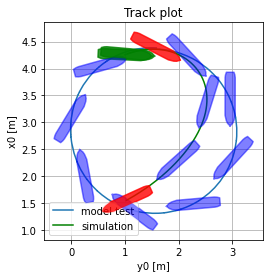

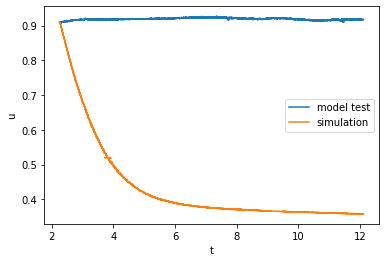

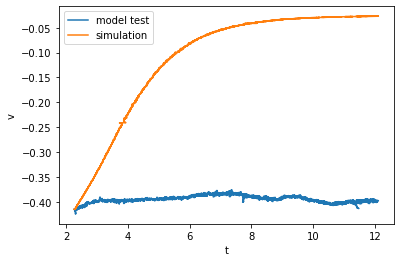

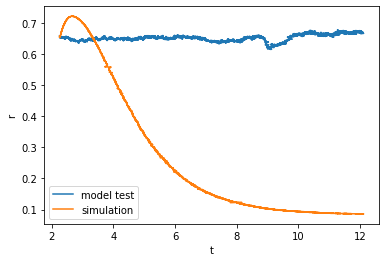

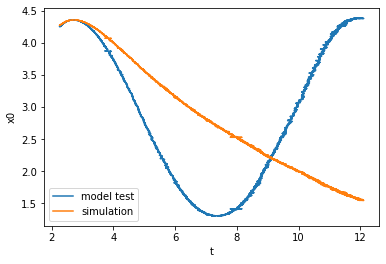

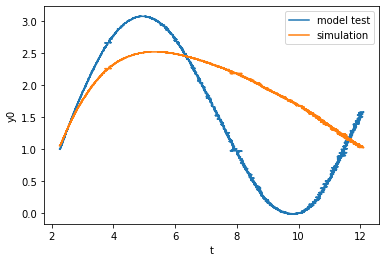

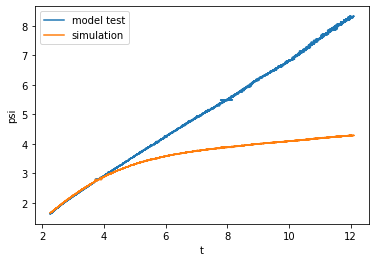

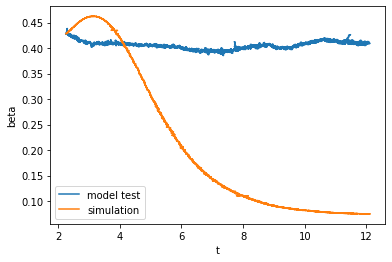

In [30]:
fig,ax=plt.subplots()
track_plot(df=df_cut_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='model test')
track_plot(df=df_result_brix, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result_brix:
    fig,ax = plt.subplots()
    df_cut_prime.plot(y=key, label='model test', ax=ax)
    df_result_brix.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)

## Back to SI

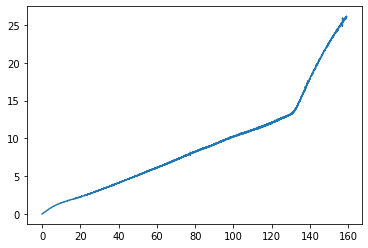

In [31]:
fig,ax=plt.subplots()
ax.plot(df.index,df_prime.index)

In [32]:
U_ = ship_parameters['L']*df_prime.index/df.index
df_unprime = ps.unprime(df_prime, U=U_)
df_unprime.index = ps._unprime(df_prime.index,unit='time',U=U_)

<AxesSubplot:xlabel='time'>

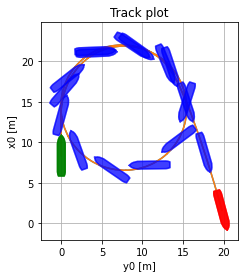

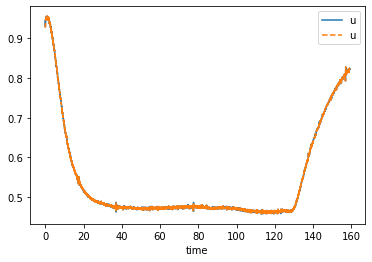

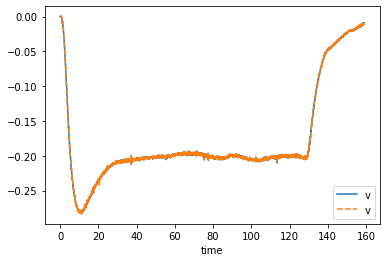

In [33]:
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);
track_plot(df=df_unprime, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

fig,ax=plt.subplots()
df.plot(y='u',ax=ax)
df_unprime.plot(y='u', style='--', ax=ax)

fig,ax=plt.subplots()
df.plot(y='v',ax=ax)
df_unprime.plot(y='v', style='--', ax=ax)

# VCT regression

## Load VCT data

In [34]:
df_VCT_all = pd.read_csv('../data/external/vct.csv', index_col=0)
df_VCT_all.head()

,level_0,Dp,S,S_Xgrid,S_inner_bracket_port,S_inner_bracket_stb,S_outer_bracket_port,S_outer_bracket_stb,S_rudder_port,S_rudder_stb,S_shaft_port_assembly,S_shaft_port_shaft1,S_shaft_port_shaft2,S_shaft_stb_assembly,S_shaft_stb_shaft1,S_shaft_stb_shaft2,V,beta,delta,fx,fx_Xgrid,fx_inner_bracket_port,fx_inner_bracket_stb,fx_outer_bracket_port,fx_outer_bracket_stb,fx_rudder_port,fx_rudder_stb,fx_shaft_port_assembly,fx_shaft_port_shaft1,fx_shaft_port_shaft2,fx_shaft_stb_assembly,fx_shaft_stb_shaft1,fx_shaft_stb_shaft2,fy,fy_Xgrid,fy_inner_bracket_port,fy_inner_bracket_stb,fy_outer_bracket_port,fy_outer_bracket_stb,fy_rudder_port,fy_rudder_stb,fy_shaft_port_assembly,fy_shaft_port_shaft1,fy_shaft_port_shaft2,fy_shaft_stb_assembly,fy_shaft_stb_shaft1,fy_shaft_stb_shaft2,fz,fz_Xgrid,fz_inner_bracket_port,fz_inner_bracket_stb,fz_outer_bracket_port,fz_outer_bracket_stb,fz_rudder_port,fz_rudder_stb,fz_shaft_port_assembly,fz_shaft_port_shaft1,fz_shaft_port_shaft2,fz_shaft_stb_assembly,fz_shaft_stb_shaft1,fz_shaft_stb_shaft2,g,lpp,mx,mx_Xgrid,mx_inner_bracket_port,mx_inner_bracket_stb,mx_outer_bracket_port,mx_outer_bracket_stb,mx_rudder_port,mx_rudder_stb,mx_shaft_port_assembly,mx_shaft_port_shaft1,mx_shaft_port_shaft2,mx_shaft_stb_assembly,mx_shaft_stb_shaft1,mx_shaft_stb_shaft2,my,my_Xgrid,my_inner_bracket_port,my_inner_bracket_stb,my_outer_bracket_port,my_outer_bracket_stb,my_rudder_port,my_rudder_stb,my_shaft_port_assembly,my_shaft_port_shaft1,my_shaft_port_shaft2,my_shaft_stb_assembly,my_shaft_stb_shaft1,my_shaft_stb_shaft2,mz,mz_Xgrid,mz_inner_bracket_port,mz_inner_bracket_stb,mz_outer_bracket_port,mz_outer_bracket_stb,mz_rudder_port,mz_rudder_stb,mz_shaft_port_assembly,mz_shaft_port_shaft1,mz_shaft_port_shaft2,mz_shaft_stb_assembly,mz_shaft_stb_shaft1,mz_shaft_stb_shaft2,r,result_file_path,rho,u,v,name,path,thrust,rev,p,phi,model_name,S_BK_port1,S_BK_stb1,fx_BK_port1,fx_BK_stb1,fy_BK_port1,fy_BK_stb1,fz_BK_port1,fz_BK_stb1,mx_BK_port1,mx_BK_stb1,my_BK_port1,my_BK_stb1,mz_BK_port1,mz_BK_stb1,S_daggerboard_middle,fx_daggerboard_middle,fy_daggerboard_middle,fz_daggerboard_middle,mx_daggerboard_middle,my_daggerboard_middle,mz_daggerboard_middle,S_R4083_ref,fx_R4083_ref,fy_R4083_ref,fz_R4083_ref,mx_R4083_ref,my_R4083_ref,mz_R4083_ref,S_Rudder_Center,S_Rudder_Port,S_Rudder_Starboard,S_hull,S_rudder,fx_Rudder_Center,fx_Rudder_Port,fx_Rudder_Starboard,fx_hull,fx_rudder,fy_Rudder_Center,fy_Rudder_Port,fy_Rudder_Starboard,fy_hull,fy_rudder,fz_Rudder_Center,fz_Rudder_Port,fz_Rudder_Starboard,fz_hull,fz_rudder,mx_Rudder_Center,mx_Rudder_Port,mx_Rudder_Starboard,mx_hull,mx_rudder,my_Rudder_Center,my_Rudder_Port,my_Rudder_Starboard,my_hull,my_rudder,mz_Rudder_Center,mz_Rudder_Port,mz_Rudder_Starboard,mz_hull,mz_rudder,torque,test type,eta0,eta0_round,fx_rudders,fy_rudders,fz_rudders,mx_rudders,my_rudders,mz_rudders,clr,S_daggerboard_port,S_daggerboard_stb,fake_index,fx_daggerboard_port,fx_daggerboard_stb,fy_daggerboard_port,fy_daggerboard_stb,fz_daggerboard_port,fz_daggerboard_stb,mx_daggerboard_port,mx_daggerboard_stb,my_daggerboard_port,my_daggerboard_stb,mz_daggerboard_port,mz_daggerboard_stb,$\frac{fx}{V^2}$,$\frac{fy}{V^2}$,$\frac{mz}{V^2}$
0,165,7.3,7375.872,7277.256591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.173333,0.0,-0.000000,-261193.992917,-252076.078409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1308.975604,-295.088406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.879028e+06,-5.881622e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80665,196.0,5.778834e+02,-1085.233044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.173220e+08,6.178902e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.236840e+05,2.386122e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,L:\proj2019\40199079-Segelfartyg-Wallenius\VCT...,1025.0,6.173333,-0.0,12knotsResistance,L:\proj2019\40199079-Segelfartyg-Wallenius\VCT...,0.0,0.0,0,0,HERO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.61946

In [35]:
df_VCT = df_VCT_all.groupby(by=['model_name']).get_group('V2_5_MDL_modelScale')

In [36]:
df_VCT['test type'].unique()

array(['resistance', 'Rudder angle', 'Drift angle',
       'Rudder and drift angle', 'Circle', 'Circle + Drift'], dtype=object)

# Subtract the resistance

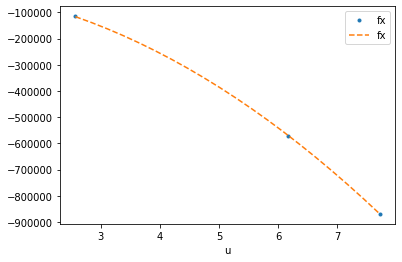

In [37]:
df_resistance = df_VCT.groupby(by='test type').get_group('resistance')

X = df_resistance[['u','fx']].copy()
X['u**2'] = X['u']**2
y = X.pop('fx')

model_resistance = sm.OLS(y,X)
results_resistance = model_resistance.fit()

X_pred = pd.DataFrame()
X_pred['u'] = np.linspace(X['u'].min(), X['u'].max(), 20)
X_pred['u**2'] = X_pred['u']**2
X_pred['fx'] = results_resistance.predict(X_pred)

fig,ax=plt.subplots()
df_resistance.plot(x='u', y='fx', style='.', ax=ax)
X_pred.plot(x='u', y='fx', style='--', ax=ax);


In [38]:
df_VCT_0_resistance = df_VCT.copy()
df_VCT_0_resistance['u**2'] = df_VCT_0_resistance['u']**2
#df_VCT_0_resistance['fx']-= results_resistance.predict(df_VCT_0_resistance[['u','u**2']])
df_VCT_0_resistance['thrust'] = results_resistance.predict(df_VCT_0_resistance[['u','u**2']])

## VCT to prime system

In [39]:
interesting = [
    'u',
    'v',
    'r',
    'delta',
    'fx',
    'fy',
    'mz',
    'thrust',
]
df_VCT_prime = ps_ship.prime(df_VCT_0_resistance[interesting], U=df_VCT_0_resistance['V'])

In [40]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred_vct(X,y,results, label):
    
    display(results.summary())
    
    X_ = X.copy()
    X_['y'] = y
    X_.sort_values(by='y', inplace=True)
        
    y_ = X_.pop('y')
    
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    #ax.plot(X_.index,y_, label='Numerical gradient from model test')
    #ax.plot(X_.index,y_pred, '--', label='OLS')
    
    ax.plot(y_,y_pred, '.')
    ax.plot([y_.min(),y_.max()], [y_.min(),y_.max()], 'r-')
    
    ax.set_ylabel(f'{label} (prediction)')    
    ax.set_xlabel(label)
    
    ax.fill_between(y_, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5% confidence')
    ax.legend();

## N

In [41]:
eq.N_qs_eq

Eq(N_qs(u(t), v(t), r(t), delta(t)), N_{deltadeltadelta}*delta(t)**3 + N_{delta}*delta(t) + N_{rdeltadelta}*delta(t)**2*r(t) + N_{rrdelta}*delta(t)*r(t)**2 + N_{rrr}*r(t)**3 + N_{r}*r(t) + N_{udelta}*delta(t)*u(t) + N_{ur}*r(t)*u(t) + N_{uudelta}*delta(t)*u(t)**2 + N_{uur}*r(t)*u(t)**2 + N_{uuv}*u(t)**2*v(t) + N_{uu}*u(t)**2 + N_{uv}*u(t)*v(t) + N_{vdeltadelta}*delta(t)**2*v(t) + N_{vrdelta}*delta(t)*r(t)*v(t) + N_{vrr}*r(t)**2*v(t) + N_{vvdelta}*delta(t)*v(t)**2 + N_{vvr}*r(t)*v(t)**2 + N_{v}*v(t))

In [42]:
label = sp.symbols('N_qs')
N_eq_ = eq.N_qs_eq.subs(N_qs,label)
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq_, label=label, base_features=[delta,u,v,r])

In [43]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     mz   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2253.
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           2.53e-32
Time:                        08:28:58   Log-Likelihood:                 359.66
No. Observations:                  36   AIC:                            -693.3
Df Residuals:                      23   BIC:                            -672.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Ndeltadeltadelta    -0.0006      0.002     -0.340      0.737      -0.004       0.003
Nrrr                -0.0029      0.000    -12.880      0.000      -0.003      -0.002
Nuu              -1.379e-06   6.41e-06     -0.215      0.832   -1.46e-05    1.19e-05
Nrdeltadelta      1.545e-10   1.03e-10      1.505      0.146   -5.79e-11    3.67e-10
Nvdeltadelta        -0.0214      0.011     -1.876      0.073      -0.045       0.002
Nrrdelta          1.369e-11   8.93e-12      1.533      0.139   -4.78e-12    3.22e-11
Nvrr                 0.0067      0.005      1.399      0.175      -0.003       0.017
Nuudelta             0.0169      0.008      2.073      0.050    3.63e-05       0.034
Nuur                13.7243      8.710      1.576      0.129      -4.294      31.742
Nuuv                 1.3277      3.770      0.352      0.728      -6.472       9.127
Nvvdelta            -0.0355      0.016     -2.176      0.040      -0.069      -0.002
Nvvr                -0.0875      0.023     -3.817      0.001      -0.135      -0.040
Nudelta             -0.0008   4.73e-05    -16.103      0.000      -0.001      -0.001
Nur                -27.3629     17.399     -1.573      0.129     -63.356       8.630
Nuv                 -2.6131      7.468     -0.350      0.730     -18.061      12.835
Nvrdelta                  0          0        nan        nan           0           0
Ndelta              -0.0185      0.008     -2.280      0.032      -0.035      -0.002
Nr                  13.6367      8.689      1.569      0.130      -4.338      31.611
Nv                   1.2841      3.698      0.347      0.732      -6.365       8.933
==============================================================================
Omnibus:                        5.041   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                5.011
Skew:                          -0.261   Prob(JB):                       0.0816
Kurtosis:                       4.752   Cond. No.                     1.35e+35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.02e-69. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

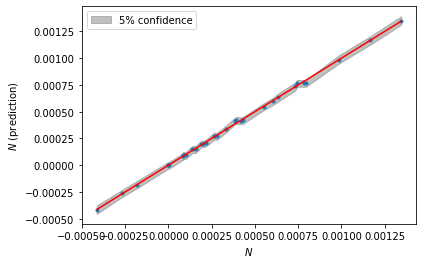

In [44]:
X = diff_eq_N.calculate_features(data=df_VCT_prime)
y = diff_eq_N.calculate_label(y=df_VCT_prime['mz'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred_vct(X=X,y=y,results=results_N, label=r'$N$')

## Y

In [45]:
eq.Y_qs_eq

Eq(Y_qs(u(t), v(t), r(t), delta(t)), Y_{delta}*delta(t) + Y_{rrr}*r(t)**3 + Y_{r}*r(t) + Y_{udelta}*delta(t)*u(t) + Y_{ur}*r(t)*u(t) + Y_{uudelta}*delta(t)*u(t)**2 + Y_{uur}*r(t)*u(t)**2 + Y_{uuv}*u(t)**2*v(t) + Y_{uu}*u(t)**2 + Y_{uv}*u(t)*v(t) + Y_{vdeltadelta}*delta(t)**2*v(t) + Y_{vrdelta}*delta(t)*r(t)*v(t) + Y_{vrr}*r(t)**2*v(t) + Y_{vvr}*r(t)*v(t)**2 + Y_{vvv}*v(t)**3 + Y_{v}*v(t))

In [46]:
label = sp.symbols('Y_qs')
Y_eq_ = eq.Y_qs_eq.subs(Y_qs,label)
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq_, label=label, base_features=[delta,u,v,r])

In [47]:
Math(vlatex(diff_eq_Y.acceleration_equation))

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fy   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5266.
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           8.67e-38
Time:                        08:28:59   Log-Likelihood:                 334.13
No. Observations:                  36   AIC:                            -644.3
Df Residuals:                      24   BIC:                            -625.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Yrrr            -0.0006      0.000     -1.424      0.167      -0.002       0.000
Yuu           -6.31e-06   1.18e-05     -0.535      0.598   -3.06e-05     1.8e-05
Yvvv            -0.1402      0.048     -2.900      0.008      -0.240      -0.040
Yvdeltadelta     0.0431      0.019      2.232      0.035       0.003       0.083
Yvrr            -0.0266      0.010     -2.800      0.010      -0.046      -0.007
Yuudelta        -0.1057      0.040     -2.638      0.014      -0.188      -0.023
Yuur            43.6811     17.232      2.535      0.018       8.117      79.246
Yuuv             6.7164      7.433      0.904      0.375      -8.625      22.058
Yvvr            -0.1010      0.045     -2.227      0.036      -0.195      -0.007
Yudelta          0.0015   8.43e-05     17.264      0.000       0.001       0.002
Yur            -87.2584     34.422     -2.535      0.018    -158.301     -16.216
Yuv            -13.3015     14.818     -0.898      0.378     -43.884      17.281
Yvrdelta              0          0        nan        nan           0           0
Ydelta           0.1092      0.040      2.722      0.012       0.026       0.192
Yr              43.5801     17.190      2.535      0.018       8.102      79.058
Yv               6.5762      7.385      0.890      0.382      -8.666      21.819
==============================================================================
Omnibus:                        8.124   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                6.741
Skew:                           0.914   Prob(JB):                       0.0344
Kurtosis:                       4.074   Cond. No.                     3.03e+33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.02e-66. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

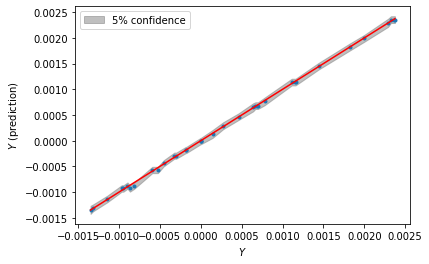

In [48]:
X = diff_eq_Y.calculate_features(data=df_VCT_prime)
y = diff_eq_Y.calculate_label(y=df_VCT_prime['fy'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred_vct(X=X,y=y,results=results_Y, label=r'$Y$')

## X

In [49]:
eq.X_qs_eq

Eq(X_qs(u(t), v(t), r(t), delta(t)), X_{deltadelta}*delta(t)**2 + X_{rdelta}*delta(t)*r(t) + X_{rr}*r(t)**2 + X_{thrust}*thrust(t) + X_{udeltadelta}*delta(t)**2*u(t) + X_{urdelta}*delta(t)*r(t)*u(t) + X_{urr}*r(t)**2*u(t) + X_{uuu}*u(t)**3 + X_{uu}*u(t)**2 + X_{uvr}*r(t)*u(t)*v(t) + X_{uvv}*u(t)*v(t)**2 + X_{u}*u(t) + X_{vdelta}*delta(t)*v(t) + X_{vrdelta}*delta(t)*r(t)*v(t) + X_{vr}*r(t)*v(t) + X_{vv}*v(t)**2)

In [50]:
label = sp.symbols('X_qs')
X_eq_ = eq.X_qs_eq.subs(X_qs,label)
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq_, label=label, base_features=[delta,u,v,r,thrust])

In [51]:
Math(vlatex(diff_eq_X.acceleration_equation))

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fx   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     154.9
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           1.66e-19
Time:                        08:29:00   Log-Likelihood:                 370.71
No. Observations:                  36   AIC:                            -717.4
Df Residuals:                      24   BIC:                            -698.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Xdeltadelta     -0.4113      0.136     -3.023      0.006      -0.692      -0.130
Xrr              0.1017      0.073      1.401      0.174      -0.048       0.252
Xuu           -319.0252    270.500     -1.179      0.250    -877.310     239.260
Xuuu           133.2367    112.936      1.180      0.250     -99.852     366.326
Xvv            -78.8329     66.944     -1.178      0.251    -216.999      59.333
Xudeltadelta     0.4089      0.136      3.005      0.006       0.128       0.690
Xurr            -0.1016      0.073     -1.399      0.175      -0.251       0.048
Xuvv            52.5518     44.628      1.178      0.251     -39.555     144.659
Xrdelta       3.259e-10   2.76e-10      1.179      0.250   -2.44e-10    8.96e-10
Xvdelta         -0.0010      0.001     -0.649      0.523      -0.004       0.002
Xvr             -0.0832      0.224     -0.371      0.714      -0.546       0.380
Xurdelta     -4.483e-14    3.8e-14     -1.179      0.250   -1.23e-13    3.36e-14
Xvrdelta              0          0        nan        nan           0           0
Xuvr             0.0787      0.225      0.350      0.730      -0.385       0.543
Xthrust          1.0113      0.033     31.104      0.000       0.944       1.078
Xu             185.7885    157.564      1.179      0.250    -139.408     510.985
==============================================================================
Omnibus:                        1.164   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                0.370
Skew:                          -0.138   Prob(JB):                        0.831
Kurtosis:                       3.413   Cond. No.                     1.69e+34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.74e-67. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

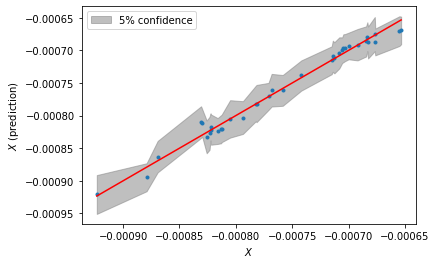

In [52]:
X = diff_eq_X.calculate_features(data=df_VCT_prime)
y = diff_eq_X.calculate_label(y=df_VCT_prime['fx'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred_vct(X=X,y=y,results=results_X, label=r'$X$')

In [53]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [54]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['prime'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

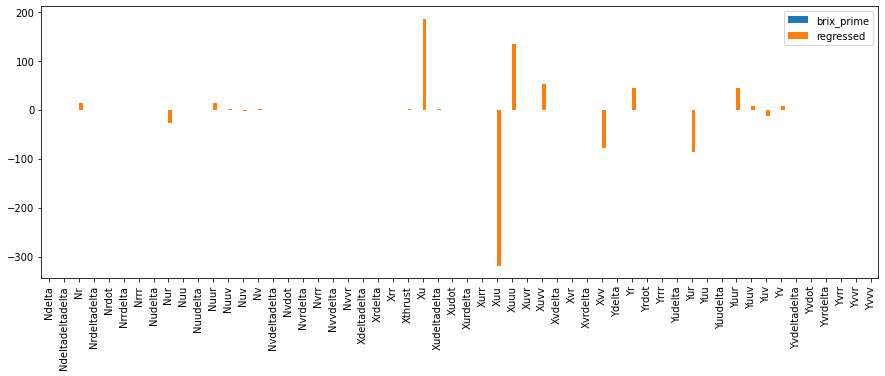

In [55]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)

mask = ((df_parameters_all['brix_prime']!=0) |
        (pd.notnull(df_parameters_all['regressed'])))
                
df_parameters_all_plot = df_parameters_all.loc[mask]
df_parameters_all_plot.plot.bar(y=['brix_prime','regressed'], ax=ax);

## Simulate

In [ ]:
parameters = df_parameters_all['prime'].copy()
parameters['Xthrust']*=0.7
solution, df_result_VCT = simulate(df_cut_prime, parameters = parameters, ship_parameters=ship_parameters_prime)

In [ ]:
fig,ax=plt.subplots()
track_plot(df=df_cut_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='model test')
track_plot(df=df_result_VCT, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result_VCT:
    fig,ax = plt.subplots()
    df_cut_prime.plot(y=key, label='model test', ax=ax)
    df_result_VCT.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)

# Time series PIT

In [ ]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

## N

In [ ]:
N_eq_ = N_eq.copy()
N_eq_ = N_eq_.subs([
    (x_G,0),  # Assuming or moving to CG=0
#    #(I_z,1),  # Removing inertia
#    #(eq.p.Nrdot,0),  # Removing added mass
#    #(eq.p.Nvdot,0),  # Removing added mass
#    #(eq.p.Nudot,0),  # Removing added mass
#    
])  

solution = sp.solve(N_eq_,r.diff())[0]
inertia_ = (I_z-eq.p.Nrdot)
N_eq_ = sp.Eq(r.diff()*inertia_, solution*inertia_)


In [ ]:
Math(vlatex(N_eq_))

In [ ]:
label_N = N_eq_.lhs
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq_, label=label_N, base_features=[delta,u,v,r])

In [ ]:
Math(vlatex(diff_eq_N.acceleration_equation))

In [ ]:
Math(vlatex(diff_eq_N.acceleration_equation_x))

In [ ]:
Math(vlatex(diff_eq_N.eq_y))

In [ ]:
diff_eq_N.eq_beta

In [ ]:
Math(vlatex(diff_eq_N.eq_X))

In [ ]:
diff_eq_N.y_lambda

In [ ]:
X = diff_eq_N.calculate_features(data=df_prime)
y = run(function=diff_eq_N.y_lambda, inputs=df_prime, **ship_parameters_prime, **df_parameters_all['brix_prime'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$%s$' % vlatex(label_N))

## Y

In [ ]:
Y_eq_ = Y_eq.copy()
Y_eq_ = Y_eq.subs([
    (x_G,0),  # Assuming or moving to CG=0
#    #(I_z,1),  # Removing inertia
#    #(eq.p.Nrdot,0),  # Removing added mass
#    #(eq.p.Nvdot,0),  # Removing added mass
#    #(eq.p.Nudot,0),  # Removing added mass
#    
])  

solution = sp.solve(Y_eq_,v.diff())[0]
inertia_ = (eq.p.Yvdot-m)
Y_eq_ = sp.Eq(-(v.diff()*inertia_-u*m*r), -(solution*inertia_-u*m*r))

Math(vlatex(Y_eq_))

In [ ]:
label_Y = Y_eq_.lhs
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq_, label=label_Y, base_features=[delta,u,v,r])

In [ ]:
X = diff_eq_Y.calculate_features(data=df_prime)
y = run(function=diff_eq_Y.y_lambda, inputs=df_prime, **ship_parameters_prime, **df_parameters_all['brix_prime'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$%s$' % vlatex(label_Y))

## X

In [ ]:
X_eq_ = X_eq.copy()
X_eq_ = X_eq_.subs([
    (x_G,0),  # Assuming or moving to CG=0
#    #(I_z,1),  # Removing inertia
#    #(eq.p.Nrdot,0),  # Removing added mass
#    #(eq.p.Nvdot,0),  # Removing added mass
#    #(eq.p.Nudot,0),  # Removing added mass
#    
])  

solution = sp.solve(X_eq_,u.diff())[0]
inertia_ = m-eq.p.Xudot
X_eq_ = sp.Eq((u.diff()*inertia_-m*r*v), (solution*inertia_-m*r*v))

Math(vlatex(X_eq_))

In [ ]:
label_X = X_eq_.lhs
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq_, label=label_X, base_features=[delta,u,v,r,thrust])

In [ ]:
X = diff_eq_X.calculate_features(data=df_prime)
y = run(function=diff_eq_X.y_lambda, inputs=df_prime, **ship_parameters_prime, **df_parameters_all['brix_prime'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$%s$' % vlatex(label_X))

In [ ]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add regressed parameters

In [ ]:
results = pd.concat([results_summary_X, results_summary_Y, results_summary_N],axis=0)
df_parameters_all['PIT'] = results['coeff']
df_parameters_all['PIT'] = df_parameters_all['PIT'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)

mask = ((df_parameters_all['brix_prime']!=0) |
        (pd.notnull(df_parameters_all['regressed'])) | 
        (df_parameters_all['PIT']!=0)
        
       )
                
df_parameters_all_plot = df_parameters_all.loc[mask]

df_parameters_all_plot.drop(index=['Xthrust']).plot.bar(y=['brix_prime','regressed','PIT'], ax=ax);

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
df_parameters_all_plot.loc[['Xthrust']].plot.bar(y=['brix_prime','regressed','PIT'], ax=ax);

## Simulate

In [ ]:
parameters = df_parameters_all['PIT'].copy()
#parameters['Xv']=0
#parameters['Xr']=0
#parameters['Xu']=0
#parameters['Xdelta']=0
#parameters['Nv']*=-1



solution, df_result_PIT = simulate(df_cut_prime, parameters = parameters, ship_parameters=ship_parameters_prime)

In [ ]:
fig,ax=plt.subplots()
track_plot(df=df_cut_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='model test')
track_plot(df=df_result_PIT, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result_PIT:
    fig,ax = plt.subplots()
    df_cut_prime.plot(y=key, label='model test', ax=ax)
    df_result_PIT.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)

In [ ]:
X_eq

In [ ]:
u1d,v1d,r1d = sp.symbols('u1d, v1d, r1d')
subs = [
    (u.diff(),u1d),
    (v.diff(),v1d),
    (r.diff(),r1d),

]
eq_X_ = X_eq.subs(subs)
eq_Y_ = Y_eq.subs(subs)
eq_N_ = N_eq.subs(subs)


A,b = sp.linear_eq_to_matrix([eq_X_,eq_Y_,eq_N_],[u1d,v1d,r1d])

In [ ]:
A

In [ ]:
Math(vlatex(b))

In [ ]:
A.inv()